# COVID-19 Detection
##### use R-CNN




1.selective search 

2.AlexNet 

3.SVM 



In [1]:
import os# 读取文件

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm 





# 路径储存

In [2]:
# read impage path
filePath = "train"

list1 = [filePath+ '/' + i for i in os.listdir(filePath)]
list2 = []
list3 = []
for i in range(len(list1)):
    for path in os.listdir(list1[i]):
        list2.append (list1[i]+ '/' +path)


for i in range(len(list2)):
    for path in os.listdir(list2[i]):
        list3.append (list2[i]+ '/' +path)
len(list3)

6334

# 图片转换
### dicom 转 jpg

In [3]:
##---------------------------------------
#dicom to pixel array converting function
##---------------------------------------

# Ref : https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def dicom2arr(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    if voi_lut:
        arr = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        arr = dicom.pixel_array
               
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        arr = np.amax(arr) - arr
        
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    arr = (arr * 255).astype(np.uint8)
        
    return arr

##-----------------------
#resizing the pixel array
##-----------------------

def resizeArr(arr,is_train=True):
    im = Image.fromarray(arr)
    im = im.resize((1024,1024),resample= Image.LANCZOS)
    return im


##------------------------------
#Filename for resized jpg images 
##------------------------------

def getFilename(filepath,is_train=True):
    '''
        Fromat = '{STUDY-ID}_{SUB-STUDY-ID}_{IMAGE-ID}.jpg'
    '''
    ls = filepath.split("/")
    filename = ls[-1].split(".")[0]+".jpg"
    return filename

##-------------------
#Finally saving image
##-------------------

def saveImage(filepath,mainpath,train=True):
    arr = dicom2arr(filepath)
    arr = resizeArr(arr,train)
    path = os.path.join(mainpath,getFilename(filepath,train))
    
    arr.save(path)

In [4]:
# 储存照片
#for filepath in tqdm(list3):
    #saveImage(filepath,'trainjpg')
    

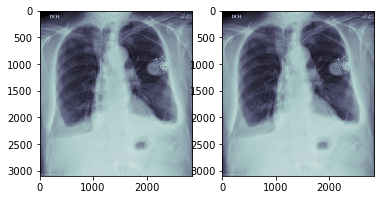

In [5]:
sample = pydicom.dcmread(list3[1]).pixel_array
sample2 = dicom2arr(list3[1])
fig =plt.figure()
ax = fig.add_subplot(121)
plt.imshow(sample, cmap=plt.cm.bone)
ax2 = fig.add_subplot(122)
plt.imshow(sample2, cmap=plt.cm.bone)
plt.show()

# 数据预处理

In [6]:
meta = pd.read_csv('meta.csv')

meta_dict = dict()
for row in meta.iterrows():
    meta_dict[row[1][0]] = [row[1][1]/1024,row[1][2]/1024]

In [7]:
# patitents->studys->images
img_info = pd.read_csv('train_image_level.csv') # include image info
study_id =pd.read_csv('train_study_level.csv')# include study info
test_info =pd.read_csv('sample_submission.csv')# 
print(len(img_info))
img_info.head(2)

6334


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed


In [8]:
# Ref : https://www.kaggle.com/shanmukh05/siim-covid-19-data-preparation-for-detectron2
classes_dict = {
    0 : "Negative for Pneumonia",
    1  : "Typical Appearance",
    2  : "Indeterminate Appearance",
    3  : "Atypical Appearance"
}

study_id.rename(columns={'id':'StudyInstanceUID'},inplace = True)
study_id['StudyInstanceUID'] = study_id['StudyInstanceUID'].apply(lambda x:x[:-6])

study_id["one_hot"] = study_id.apply(lambda x : np.array([x["Negative for Pneumonia"],
                                                        x["Typical Appearance"],
                                                        x["Indeterminate Appearance"],
                                                        x["Atypical Appearance"]]),axis=1)
study_id["label_id"] = study_id["one_hot"].map(lambda x : classes_dict[np.argmax(x)])
study_id["study_label"] = study_id["one_hot"].map(lambda x : np.argmax(x))
study_id = study_id.drop(["Negative for Pneumonia","Typical Appearance","Indeterminate Appearance","Atypical Appearance","one_hot"],axis=1)

print(len(study_id))
study_id.head(2)

6054


,StudyInstanceUID,label_id,study_label
0,00086460a852,Typical Appearance,1
1,000c9c05fd14,Atypical Appearance,3


In [9]:
train_info = pd.merge(img_info,study_id,how='left',on='StudyInstanceUID')
train_info.drop(['boxes','StudyInstanceUID','label_id'],axis=1,inplace = True)
print(len(train_info))
train_info.head(2)

6334


,id,label,study_label
0,000a312787f2_image,opacity 1 789.28836 582.43035 1815.94498 2499....,1
1,000c3a3f293f_image,none 1 0 0 1 1,0


In [10]:
# 从训练集里面分出一些认证集
num = 1000
image_ids = train_info['id'].unique()
valid_ids = image_ids[-num:]
train_ids = image_ids[:-num]
valid_index = np.arange(num)
len(train_ids)

5334

In [11]:
valid_info = train_info[train_info['id'].isin(valid_ids)]
valid_info.index = valid_index
train_info = train_info[train_info['id'].isin(train_ids)]

In [12]:
valid_info.values[0]

array(['d67e15fad409_image',
       'opacity 1 420.07079 707.25664 1334.4070900000002 1835.0441799999999 opacity 1 1662.54866 621.23894 2624.67256 1895.57518',
       1], dtype=object)

In [13]:
def boxpic(df):

    
    boxdf = pd.DataFrame(columns = ['img_id', 'box', 'label'],dtype=object)
    for i in range(len(df)):
        img_id = df.values[i][0][:-6]
        box = df.values[i][1]
        label = df.values[i][2]
        b_list = box.split(' ')
        for j in range(len(box.split(' '))//6):
            box_list= []
            box_list.append([int(float(b_list[j*6+2]))/meta_dict[img_id][1], int(float(b_list[j*6+3]))/meta_dict[img_id][0],
                         int(float(b_list[j*6+4]))/meta_dict[img_id][1], int(float(b_list[j*6+5]))/meta_dict[img_id][0]])
            #b"ox_list = np.array(box_list).astype('float64')
            boxdf = boxdf.append({'img_id': img_id, 'box': box_list[0], 'label': label}, ignore_index=True)
    return boxdf
        
        

In [14]:
train_info = boxpic(train_info)
valid_info = boxpic(valid_info)


In [40]:
valid_info.head(2)

,img_id,box,label
0,d67e15fad409,"[141.84696569920845, 287.2888888888889, 450.53...",1
1,d67e15fad409,"[561.3087071240105, 252.34285714285716, 886.20...",1


# 选择性搜索

In [16]:
cv2.setUseOptimized(True);
cv2.setNumThreads(4);
im = cv2.imread('SSexample.jpg')

# resize image

# create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set input image on which we will run segmentation
ss.setBaseImage(im)

ss.switchToSelectiveSearchFast()# fast but low recall


# run selective search segmentation on input image
rects = ss.process()  # f:453, q:1354
print('Total Number of Region Proposals: {}'.format(len(rects)))

# number of region proposals to show



Total Number of Region Proposals: 992


In [17]:
ii = []
for i in range(len(rects)):
    if rects[i][2] > 350 and rects[i][3] >550:
        if rects[i][2] < 950 and rects[i][3] <1050:
            ii.append(rects[i])

rects = np.array(ii)


In [18]:
def showpic(pic = im,ss =  rects):

    # create a copy of original image
    imOut = im.copy()
    fig =plt.figure(figsize =(10,10))
    # itereate over all the region proposals
    for i, rect in enumerate(rects):
        # draw rectangle for region proposal till numShowRects
        x, y, w, h = rect  # 这种格式
        #cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 255), 1, cv2.LINE_AA)
        subpic = imOut[y:y+h,x:x+w]
        
        ax = fig.add_subplot(4,7,i+1)
        plt.imshow(subpic, cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()
    
       


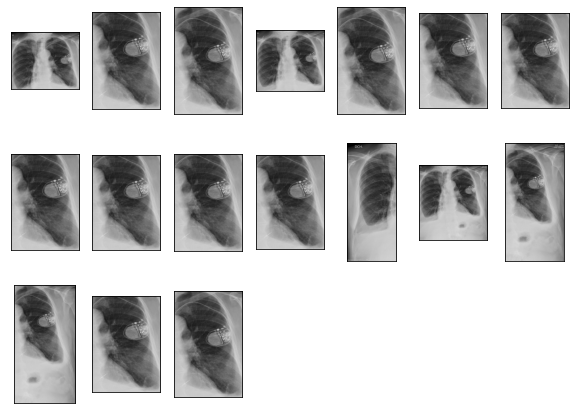

In [19]:
showpic() 

# 模型搭建和训练

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
for i in range(len(valid_info)):
    img = cv2.imread('jpg/train/'+ valid_info.values[i][0] +'.jpg')
    try:
        img.shape
    except:
        print(valid_info[i][0])

In [23]:
model = models.alexnet(num_classes = 4)

In [24]:
class CreateDataset(Dataset):
    def __init__(self, df, pth, transforms=None):
        self.ids = df["img_id"].unique()
        self.df = df
        self.pth = pth
        self.transforms = transforms

        
    def __getitem__(self, index):
        label = self.df['label'][index]

        x,y = int(self.df['box'][0][0]),int(self.df['box'][0][1])
        w,h = int(self.df['box'][0][2]),int(self.df['box'][0][3])
        img_id = self.ids[index]
        img = cv2.imread(self.pth+img_id+'.jpg',1)
        
        #img = img[y:y+h, x:x+w] if label!=0 else img
        if label!=0:
            img = img[y:y+h, x:x+w]
            
        img = cv2.resize(img,(224,224))
        img = np.transpose(img,(2,0,1))
        
        img = torch.from_numpy(img)
        label = torch.from_numpy(np.array(label))
        return img,label
    def __len__(self):
        return self.ids.shape[0]


In [25]:
train_dataset = CreateDataset(train_info,'trainjpg/', True)
valid_dataset = CreateDataset(valid_info,'trainjpg/',True)

In [26]:
batch = 256
train_data_loader = DataLoader(train_dataset,batch_size=batch,shuffle=True,num_workers=0,pin_memory=True)
valid_data_loader = DataLoader(valid_dataset,batch_size=batch,shuffle=True,num_workers=0,pin_memory=True)

In [27]:

dtype = torch.cuda.FloatTensor
model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [28]:
print(len(train_dataset))
print(len(train_data_loader))

5334
21


In [34]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        model.train()
        for x, y in tqdm(train_data_loader):
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          

In [30]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in tqdm(loader):
        x_var = Variable(x.type(dtype))
 
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [35]:
torch.cuda.synchronize()

In [38]:
torch.cuda.synchronize()
train(model, loss_fn, optimizer, num_epochs=30)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.57s/it]


In [39]:
torch.cuda.synchronize()
check_accuracy(model, valid_data_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]

Got 758 / 1000 correct (75.80)
